In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import os; os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
# from jax.config import config
# config.update("jax_debug_nans", True)

In [4]:
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

2024-02-16 11:15:02.033798: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 11:15:02.063534: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-16 11:15:02.064059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-16 11:15:02.610514: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-16 11:15:03.420463: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

In [5]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from typing import Any, Callable, Sequence, Union
import numpy as np
from fastcore.xtras import Path
from fastprogress.fastprogress import master_bar, progress_bar
import pandas as pd
import cv2

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, FreqGaussianGamma, OrientGaussianGamma
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

# Wandb config

In [6]:
id = "cw5pzd42"

In [7]:
api = wandb.Api()
prev_run = api.run(f"jorgvt/PerceptNetClassification_JaX/{id}")

In [10]:
config = ConfigDict(prev_run.config)

In [11]:
for file in prev_run.files():
    file.download(root=prev_run.dir, replace=True)

# Load the data

In [12]:
def load_imagenet():
    path_data = Path("/lustre/ific.uv.es/ml/uv075/Databases/imagenet_images/")
    dst_train = tf.keras.utils.image_dataset_from_directory(
                path_data,
                validation_split=config.validation_split,
                subset="training",
                seed=config.seed,
                shuffle=True,
                # image_size=(img_height, img_width),
                batch_size=config.batch_size)
    dst_val = tf.keras.utils.image_dataset_from_directory(
                path_data,
                validation_split=config.validation_split,
                subset="validation",
                seed=config.seed,
                shuffle=False,
                # image_size=(img_height, img_width),
                batch_size=config.batch_size)
    return dst_train, dst_val

In [13]:
def load_imagenette():
    import tensorflow_datasets as tfds

    dst_train, info = tfds.load("imagenette/320px-v2", split=f"train[:{(1-config.validation_split)*100:.0f}%]", with_info=True, shuffle_files=True)
    dst_val = tfds.load("imagenette/320px-v2", split=f"train[{(1-config.validation_split)*100:.0f}%:]", with_info=False, shuffle_files=False)
    def prepare_tfds(item):
        x, y = item["image"], item["label"]
        x = tf.image.resize_with_crop_or_pad(x, 256, 256)
        return x, y
    dst_train = dst_train.map(prepare_tfds)
    dst_val = dst_val.map(prepare_tfds)

    return dst_train.batch(config.batch_size), dst_val.batch(config.batch_size), info.features["label"].num_classes

In [14]:
def load_cifar10():
    from tensorflow.keras.datasets import cifar10
    from sklearn.model_selection import train_test_split

    (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=config.validation_split, random_state=config.seed)
    dst_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dst_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

    return dst_train.batch(config.batch_size), dst_val.batch(config.batch_size)

In [15]:
def load_cifar100():
    from tensorflow.keras.datasets import cifar100
    from sklearn.model_selection import train_test_split

    (X_train, Y_train), (X_test, Y_test) = cifar100.load_data()
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=config.validation_split, random_state=config.seed)
    dst_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dst_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

    return dst_train.batch(config.batch_size), dst_val.batch(config.batch_size)

In [16]:
if config.dataset == "imagenet":
    dst_train, dst_val = load_imagenet()
    dst_train = dst_train.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))
    dst_val = dst_val.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))
    N_CLASSES = len(dst_train.class_names)
elif config.dataset == "cifar10":
    dst_train, dst_val = load_cifar10()
    dst_train = dst_train.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y[:,0]))
    dst_val = dst_val.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y[:,0]))
    N_CLASSES = 10
elif config.dataset == "cifar100":
    dst_train, dst_val = load_cifar100()
    dst_train = dst_train.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y[:,0]))
    dst_val = dst_val.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y[:,0]))
    N_CLASSES = 100
elif config.dataset == "imagenette":
    dst_train, dst_val, N_CLASSES = load_imagenette()
    dst_train = dst_train.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))
    dst_val = dst_val.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y))
else:
    raise ValueError("Dataset parameter not allowed.")
print(f"Training on {config.dataset} with {N_CLASSES} classes.")

Training on imagenette with 10 classes.


In [17]:
x, y = next(iter(dst_train.as_numpy_iterator()))
input_shape = x[0].shape
input_shape, y.shape

((256, 256, 3), (64,))

In [19]:
# dst_tid2013 = TID2013("/lustre/ific.uv.es/ml/uv075/Databases/IQA/TID/TID2013").dataset\
#                                                                               .batch(config.batch_size)\
#                                                                               .prefetch(1)
dst_tid2013 = TID2013("/media/databases/IQA/TID/TID2013").dataset\
                                                         .batch(config.batch_size)\
                                                         .prefetch(1)                                                                              

### Performance

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

dst_train_rdy = dst_train.cache().prefetch(buffer_size=1)
dst_val_rdy = dst_val.cache().prefetch(buffer_size=1)

# Define the model

In [21]:
#| exporti
class FreqOrientGaussianGamma(nn.Module):
    """(1D) Gaussian interaction between frequencies and orientations optimizing gamma = 1/sigma instead of sigma."""
    use_bias: bool = False
    strides: int = 1
    padding: str = "SAME"
    bias_init: Callable = nn.initializers.zeros_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 **kwargs,
                 ):
        gamma_f = self.param("gamma_f",
                             k_array(1/0.4, arr=fmean),
                             (inputs.shape[-1],))
        gamma_theta = self.param("gamma_theta",
                                 equal_to(jnp.ones(shape=(len(theta_mean),)) * (1/20)),
                                 (inputs.shape[-1],))
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (len(fmean),))
        else: bias = 0.
        # n_groups = inputs.shape[-1] // len(fmean)
        kernel = jax.vmap(self.gaussian, in_axes=(None,None,0,0,0,0,None), out_axes=1)(fmean, theta_mean, fmean, theta_mean, gamma_f, gamma_theta, 1)
        kernel = kernel[None,None,:,:]
        # kernel = jnp.tile(kernel, reps=n_groups)

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv_general_dilated(
                jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
                jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
                (self.strides, self.strides),
                self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gaussian(f, theta, fmean, theta_mean, gamma_f, gamma_theta, A=1):
        return A*jnp.exp(-((gamma_f**2)*(f-fmean)**2)/(2))*jnp.exp(-((gamma_theta**2)*(theta-theta_mean)**2)/(2))

In [22]:
class GDNSpatioFreqOrient(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    # inputs_star: float = 1.
    # outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 train=False,
                 ):
        b, h, w, c = inputs.shape
        bias = self.param("bias",
                          #equal_to(inputs_star/10),
                          self.bias_init,
                          (c,))
        # is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (len(self.inputs_star),))
        # inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        GL = GaussianLayerGamma(features=c, kernel_size=self.kernel_size, strides=self.strides, padding="VALID", fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=False, feature_group_count=c)
        FOG = FreqOrientGaussianGamma()
        outputs = GL(pad_same_from_kernel_size(inputs, kernel_size=self.kernel_size, mode=self.padding)**self.alpha, train=train)#/(self.kernel_size**2)
        outputs = FOG(outputs, fmean=fmean, theta_mean=theta_mean)

        ## Coef
        # coef = GL(inputs_star_**self.alpha, train=train)#/(self.kernel_size**2)
        # coef = FG(coef, fmean=fmean)
        # coef = rearrange(coef, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = OG(coef, theta_mean=theta_mean) + bias
        # coef = rearrange(coef, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = jnp.clip(coef+bias, a_min=1e-5)**self.epsilon
        # # coef = inputs_star.value * coef
        # if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star

        # if is_initialized and train:
        #     inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95, axis=(0,1,2)))/2
        # return coef * inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)
        return inputs / (jnp.clip(outputs+bias, a_min=1e-5)**self.epsilon + self.eps)

In [23]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(inputs)
        
        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False, name="Color")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.CS_KERNEL_SIZE, mode="symmetric")
        outputs = CenterSurroundLogSigmaK(features=3, kernel_size=config.CS_KERNEL_SIZE, fs=21, use_bias=False, padding="VALID")(outputs, **kwargs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs = GDNGaussian(kernel_size=config.GDNGAUSSIAN_KERNEL_SIZE, apply_independently=True, fs=32, padding="symmetric", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY)(outputs, **kwargs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.GABOR_KERNEL_SIZE, mode="symmetric")
        outputs, fmean, theta_mean = GaborLayerGammaRepeat(features=config.N_GABORS, kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS, train_A=config.A_GABOR)(outputs, return_freq=True, return_theta=True, **kwargs)
        
        ## Final GDN mixing Gabor information (?)
        outputs = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="symmetric", fs=32, apply_independently=False)(outputs, fmean=fmean, theta_mean=theta_mean, **kwargs)

        return outputs

In [24]:
class Classifier(nn.Module):
    N_CLASSES: int
    GAP: bool = False
    dropout_rate: float = 0.5

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        outputs = reduce(inputs, "b h w c -> b c", reduction="mean") if self.GAP else rearrange(inputs, "b h w c -> b (h w c)")
        outputs = nn.Dropout(rate=self.dropout_rate, deterministic=not train)(outputs) if self.dropout_rate > 0.0 else outputs
        outputs = nn.Dense(self.N_CLASSES)(outputs)
        return outputs

In [25]:
class PerceptNetClassifier(nn.Module):
    """Classifier with a PerceptNet backbone."""

    def setup(self):
        self.perceptnet = PerceptNet()
        self.cls = Classifier(N_CLASSES=N_CLASSES, GAP=config.GAP, dropout_rate=config.dropout_rate)

    def __call__(self,
                 inputs,
                 train=False,
                 ):
        outputs = self.perceptnet(inputs, train=train)
        outputs = self.cls(outputs, train=train)
        return outputs

In [26]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output("loss")

In [27]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict
    key: jax.Array

In [28]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape), train=False)
    _, dropout_key = random.split(random.PRNGKey(42))
    state, params = variables.pop('params')
   
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        key=dropout_key,
        tx=tx,
        metrics=Metrics.empty()
    )

In [150]:
state = create_train_state(PerceptNetClassifier(), random.PRNGKey(config.seed), optax.adam(config.learning_rate), input_shape=(1,*(x.shape[1:])))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
state = state.replace(params=clip_param(state.params, "A", a_min=0))
state = state.replace(params=clip_param(state.params, "K", a_min=1+1e-5))

In [167]:
batch = next(dst_train_rdy.as_numpy_iterator())
img_pred, updated_state = state.apply_fn({"params": state.params, **state.state}, batch[0], train=True, mutable=list(state.state.keys()))
state = state.replace(state=updated_state)

2024-02-16 12:42:12.732081: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [30]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [31]:
# state = orbax_checkpointer.restore(f"{prev_run.dir}/model-best", item=state)

In [34]:
from glob import glob

In [51]:
model_paths

['/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-1/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-7/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-2/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-6/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-3/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-5/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-0/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-8/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-4/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-9/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-24/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-15/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-12/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-11/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-17/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd4

In [54]:
from natsort import natsorted
    
model_paths = natsorted(glob(f"{prev_run.dir}/model-[0-9]*/"))
model_paths

['/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-0/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-1/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-2/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-3/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-4/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-5/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-6/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-7/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-8/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-9/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-10/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-11/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-12/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-13/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd42/model-14/',
 '/tmp/jorgvt/PerceptNetClassification_JaX/cw5pzd4

In [168]:
states = [orbax_checkpointer.restore(path, item=state) for path in model_paths]
states.insert(0, state)

Differences between parameters

In [154]:
def tree_diff(tree1, tree2): return jax.tree_util.tree_map(lambda x,y: jnp.mean((x-y)**2), tree1, tree2)

In [155]:
import flax

In [156]:
def process_tree(tree): return {"_".join(k):v for k,v in flax.traverse_util.flatten_dict(tree).items()}

In [157]:
diffs = []
for s1, s2 in zip(states[:-1], states[1:]):
    diff = tree_diff(s1.params, s2.params)
    diff = process_tree(diff)
    diffs.append(diff)
    # break

In [158]:
diffs_ = {k:[] for k in diff.keys()}
for diff in diffs:
    for k, v in diff.items():
        diffs_[k].append(v)

In [159]:
import pandas as pd

In [160]:
df_prev = pd.DataFrame(diffs_)
df_prev

,cls_Dense_0_bias,cls_Dense_0_kernel,perceptnet_CenterSurroundLogSigmaK_0_A,perceptnet_CenterSurroundLogSigmaK_0_K,perceptnet_CenterSurroundLogSigmaK_0_logsigma,perceptnet_Color_kernel,perceptnet_GDNGaussian_0_GaussianLayerGamma_0_A,perceptnet_GDNGaussian_0_GaussianLayerGamma_0_bias,perceptnet_GDNGaussian_0_GaussianLayerGamma_0_gamma,perceptnet_GDNSpatioFreqOrient_0_FreqOrientGaussianGamma_0_gamma_f,...,perceptnet_GDN_0_Conv_0_bias,perceptnet_GDN_0_Conv_0_kernel,perceptnet_GDN_1_Conv_0_bias,perceptnet_GDN_1_Conv_0_kernel,perceptnet_GaborLayerGammaRepeat_0_freq,perceptnet_GaborLayerGammaRepeat_0_gammax,perceptnet_GaborLayerGammaRepeat_0_gammay,perceptnet_GaborLayerGammaRepeat_0_phase,perceptnet_GaborLayerGammaRepeat_0_sigma_theta,perceptnet_GaborLayerGammaRepeat_0_theta
0,7.5974924e-05,8.173059e-06,6.509246e-05,3.0380706e-05,4.2881424e-05,4.1046445e-05,0.00016837532,2.4588464e-05,2.6427777e-05,0.0003093608,...,2.9973846e-05,4.03656e-05,9.165479e-05,3.1312076e-05,0.000102443504,2.2575592e-05,2.1514803e-05,1.7824033e-05,1.8477798e-05,2.4827048e-05
1,5.973625e-05,6.9133907e-06,2.600661e-05,7.081362e-05,0.0001452536,1.3866809e-05,0.0006345158,1.486673e-06,6.796018e-05,0.0012428106,...,2.7700638e-05,4.91713e-06,1.227392e-05,1.9818783e-06,0.0003331288,0.00013906084,6.4831765e-05,1.11657155e-05,7.8291036e-05,7.649138e-05
2,3.5970177e-05,8.763335e-06,4.988944e-05,0.00010431809,0.00022782345,6.637532e-06,0.0016465392,2.9534422e-06,0.0001191825,0.0016202077,...,1.3159643e-05,6.1741302e-06,2.7914624e-05,5.373362e-06,0.0009803316,0.0002548129,0.000116139374,7.528439e-06,0.00011885036,4.3182004e-05
3,2.2852848e-05,6.9875055e-06,4.8678376e-05,5.6259574e-05,0.00012481894,1.3691387e-06,0.0014508981,1.4117206e-06,0.00014362611,0.0010379327,...,2.3173636e-06,6.946334e-06,5.8290025e-06,3.3853746e-06,0.0007995446,0.00033749582,0.00017875875,5.729667e-06,0.000110929424,4.1629362e-05
4,1.652954e-05,4.49509e-06,1.3423464e-05,1.9833062e-05,3.598132e-05,8.951808e-07,0.0008327258,8.980627e-07,0.00010451232,0.0004940195,...,3.87923e-07,7.696595e-06,1.5923708e-06,1.0878301e-05,0.00040049315,0.0003070225,0.00018362179,5.1108645e-06,9.422904e-05,3.184418e-05
5,1.2103722e-05,3.157802e-06,5.9596628e-06,1.0562283e-05,2.0655347e-05,7.3226266e-07,0.0005385093,8.520018e-07,5.666707e-05,0.0002777197,...,1.0506627e-07,4.7061185e-06,9.578177e-07,9.132544e-06,0.00023327506,0.00023088104,0.00014622233,4.2113134e-06,7.599663e-05,1.758336e-05
6,9.081369e-06,2.368965e-06,4.645659e-06,8.058162e-06,1.5492808e-05,5.970427e-07,0.00042464433,2.2379533e-07,2.7240754e-05,0.00018771211,...,8.7110344e-08,1.4440839e-06,7.355099e-07,8.903142e-06,0.00016283405,0.00017260511,0.00011090406,3.3572148e-06,6.026928e-05,1.0456811e-05
7,7.3692136e-06,1.8053601e-06,5.868862e-06,6.3058674e-06,1.100476e-05,6.7571784e-07,0.0003730319,1.4825457e-07,1.3819542e-05,0.00014396687,...,1.8251964e-07,1.1260857e-06,8.527979e-07,7.194565e-06,0.00012278827,0.00012895782,8.337149e-05,2.512615e-06,4.5834055e-05,6.7925084e-06
8,5.666417e-06,1.3500744e-06,2.9657028e-06,3.999858e-06,8.146939e-06,3.2946926e-07,0.00033492077,1.0159553e-07,6.602457e-06,0.00011714232,...,1.407889e-07,1.212466e-06,5.0166346e-07,4.3994637e-06,9.2705406e-05,9.4290546e-05,6.105258e-05,1.8055991e-06,3.367396e-05,4.4894923e-06
9,3.8053888e-06,9.517786e-07,1.6420114e-06,3.3118952e-06,5.5509545e-06,1.4892642e-07,0.0002899576,1.7980595e-08,4.2325346e-06,9.480009e-05,...,4.835718e-08,5.51472e-07,3.023029e-07,2.5821887e-06,6.674122e-05,6.536509e-05,4.2648357e-05,1.1975919e-06,2.333336e-05,3.0015742e-06


In [161]:
diffs = []
for s1 in states:
    diff = tree_diff(s1.params, states[0].params)
    diff = process_tree(diff)
    diffs.append(diff)
    # break

In [162]:
diffs_ = {k:[] for k in diff.keys()}
for diff in diffs:
    for k, v in diff.items():
        diffs_[k].append(v)

In [163]:
df_first = pd.DataFrame(diffs_)
df_first

,cls_Dense_0_bias,cls_Dense_0_kernel,perceptnet_CenterSurroundLogSigmaK_0_A,perceptnet_CenterSurroundLogSigmaK_0_K,perceptnet_CenterSurroundLogSigmaK_0_logsigma,perceptnet_Color_kernel,perceptnet_GDNGaussian_0_GaussianLayerGamma_0_A,perceptnet_GDNGaussian_0_GaussianLayerGamma_0_bias,perceptnet_GDNGaussian_0_GaussianLayerGamma_0_gamma,perceptnet_GDNSpatioFreqOrient_0_FreqOrientGaussianGamma_0_gamma_f,...,perceptnet_GDN_0_Conv_0_bias,perceptnet_GDN_0_Conv_0_kernel,perceptnet_GDN_1_Conv_0_bias,perceptnet_GDN_1_Conv_0_kernel,perceptnet_GaborLayerGammaRepeat_0_freq,perceptnet_GaborLayerGammaRepeat_0_gammax,perceptnet_GaborLayerGammaRepeat_0_gammay,perceptnet_GaborLayerGammaRepeat_0_phase,perceptnet_GaborLayerGammaRepeat_0_sigma_theta,perceptnet_GaborLayerGammaRepeat_0_theta
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.5974924e-05,8.173059e-06,6.509246e-05,3.0380706e-05,4.2881424e-05,4.1046445e-05,0.00016837532,2.4588464e-05,2.6427777e-05,0.0003093608,...,2.9973846e-05,4.03656e-05,9.165479e-05,3.1312076e-05,0.000102443504,2.2575592e-05,2.1514803e-05,1.7824033e-05,1.8477798e-05,2.4827048e-05
2,0.00026688108,2.7629361e-05,0.00014240584,0.00013562806,0.00026965587,3.5314766e-05,0.00015256356,1.5507383e-05,0.00015400289,0.001811738,...,1.1417247e-05,2.5648505e-05,0.00014881865,3.1845073e-05,0.00062377536,0.0002101825,0.00012833969,5.0434377e-05,0.00013020552,0.00015504101
3,0.00049165066,6.361998e-05,0.00029915644,0.00044387244,0.000957685,6.4524276e-05,0.0027951654,7.864567e-06,0.00051158946,0.006435736,...,3.677495e-05,4.480789e-05,0.00030274125,5.974042e-05,0.0028705685,0.0008648195,0.0004388439,8.830924e-05,0.00045927797,0.00031964434
4,0.00071443,0.00010518952,0.0004150889,0.0007668862,0.0016943672,7.974035e-05,0.008271329,1.5296548e-05,0.0011422806,0.012398124,...,5.340993e-05,8.285523e-05,0.00038337018,6.585772e-05,0.006438906,0.0021559845,0.0010757358,0.00012428447,0.0009469037,0.0004706883
5,0.0009335337,0.00014086282,0.0004627284,0.0009875803,0.0021279214,8.4573214e-05,0.014346696,1.2822804e-05,0.0018810168,0.017596496,...,5.672618e-05,0.00013572208,0.0003911337,5.965761e-05,0.009710666,0.0039681676,0.0020341864,0.00016731699,0.00152245,0.00064019836
6,0.0011401862,0.00017153719,0.00052566535,0.0011835173,0.002517109,9.454248e-05,0.020339971,1.0508695e-05,0.0025359143,0.022022951,...,6.132806e-05,0.00018882079,0.0004182518,7.130327e-05,0.01259696,0.0060216966,0.0031735112,0.00021346682,0.0021666598,0.000803057
7,0.0013332182,0.00019897474,0.00059483724,0.0013706408,0.002887396,0.000104210325,0.026294332,9.009562e-06,0.0030506856,0.025924493,...,6.405608e-05,0.00022132776,0.0004494164,9.411517e-05,0.015257975,0.008156635,0.004383051,0.0002581042,0.0028536592,0.00094865955
8,0.0015186532,0.00022389805,0.0006844406,0.0015481213,0.0032178678,0.00011459043,0.0323673,7.4556274e-06,0.003453074,0.029436404,...,6.620129e-05,0.00025378034,0.00048697408,0.00013210262,0.017754642,0.010268008,0.005592704,0.0002975506,0.0035446992,0.0010758312
9,0.0016908704,0.00024622816,0.00075591233,0.0016825087,0.0035117709,0.0001239061,0.038543325,6.135456e-06,0.0037500486,0.03259525,...,6.888469e-05,0.00028851966,0.00051822106,0.00017152271,0.020060474,0.012267355,0.006744505,0.00032997425,0.0042037205,0.001182537


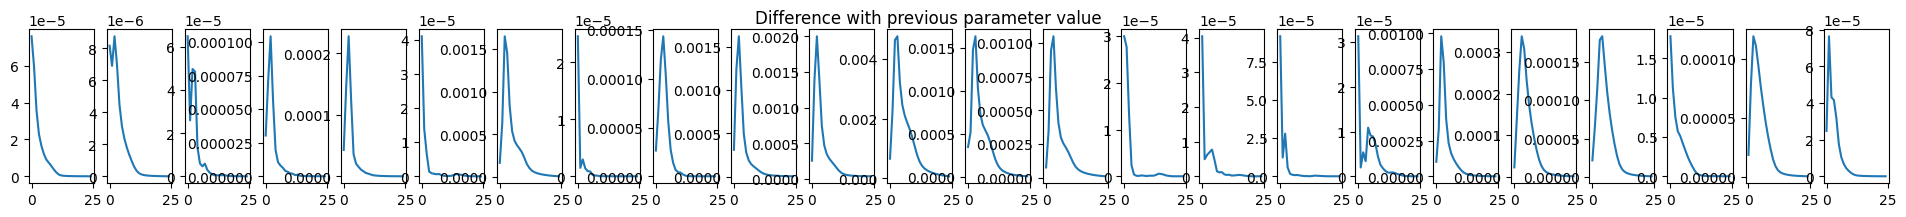

In [164]:
fig, axes = plt.subplots(1, len(df_prev.columns), figsize=(24,2))
for c, ax in zip(df_prev.columns, axes.ravel()):
    ax.plot(df_prev[c])
plt.suptitle("Difference with previous parameter value")
plt.show()

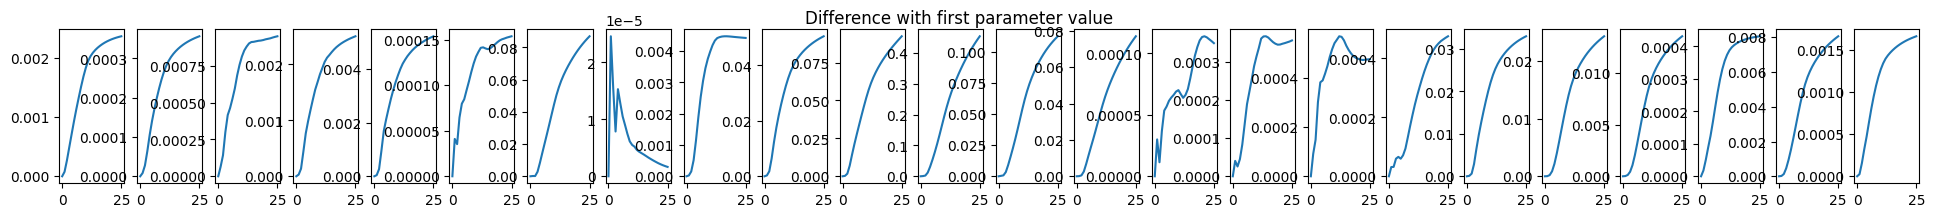

In [165]:
fig, axes = plt.subplots(1, len(df_first.columns), figsize=(24,2))
for c, ax in zip(df_first.columns, axes.ravel()):
    ax.plot(df_first[c])
plt.suptitle("Difference with first parameter value")
plt.show()

Representation of the filters

In [83]:
def plot_filters(kernel):
    kx, ky, cin, cout = kernel.shape
    fig, axes = plt.subplots(cin, cout, squeeze=False)
    for i in range(cin):
        for j in range(cout):
            axes[i,j].imshow(kernel[:,:,i,j])
            axes[i,j].axis("off")
    plt.show()

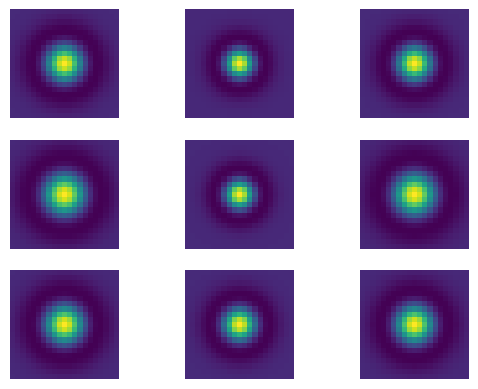

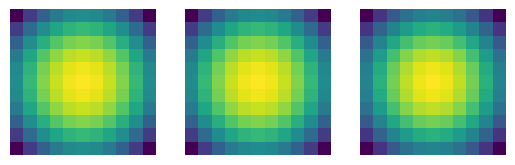

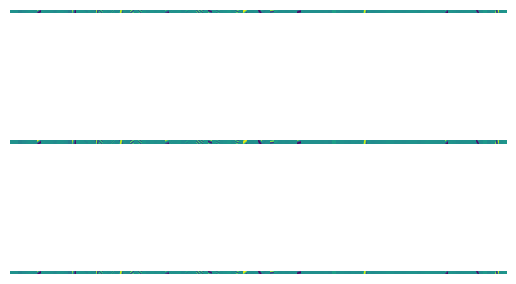

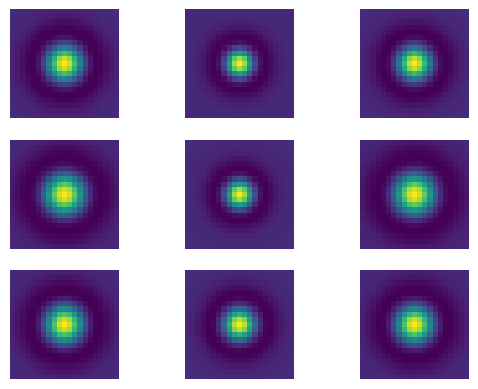

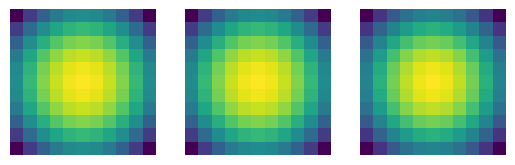

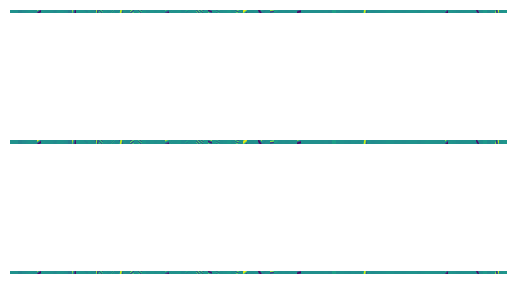

In [169]:
for i, state in enumerate(states):
    __ = jax.tree_util.tree_map(lambda x: plot_filters(x), state.state)
    if i == 1: break

## Curves

In [56]:
import matplotlib.pyplot as plt

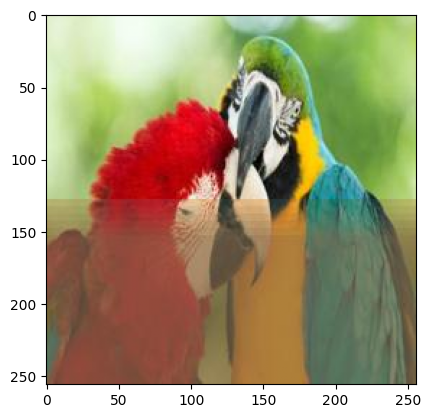

In [57]:
kk = cv2.imread("loritos_jesus_2.jpeg")
kk = cv2.cvtColor(kk, cv2.COLOR_BGR2RGB)/255.
plt.imshow(kk)
plt.show()
kk = kk[None,:]

In [66]:
def forward_pass(state, img):
    img_pred = PerceptNet().apply({"params": state.params["perceptnet"], **{"precalc_filter": state.state["precalc_filter"]["perceptnet"]}}, img)
    return img_pred

In [59]:
@jax.jit
def forward_intermediates(state, inputs):
    return PerceptNet().apply({"params": state.params["perceptnet"], **{"precalc_filter": state.state["precalc_filter"]["perceptnet"]}}, inputs, train=False, capture_intermediates=True)

In [170]:
%%time
intermediates = [forward_intermediates(state, kk)[1] for state in states]

CPU times: user 393 ms, sys: 7.09 ms, total: 400 ms
Wall time: 389 ms


In [171]:
layer_name = "GDN_0"
# state.params[layer_name]

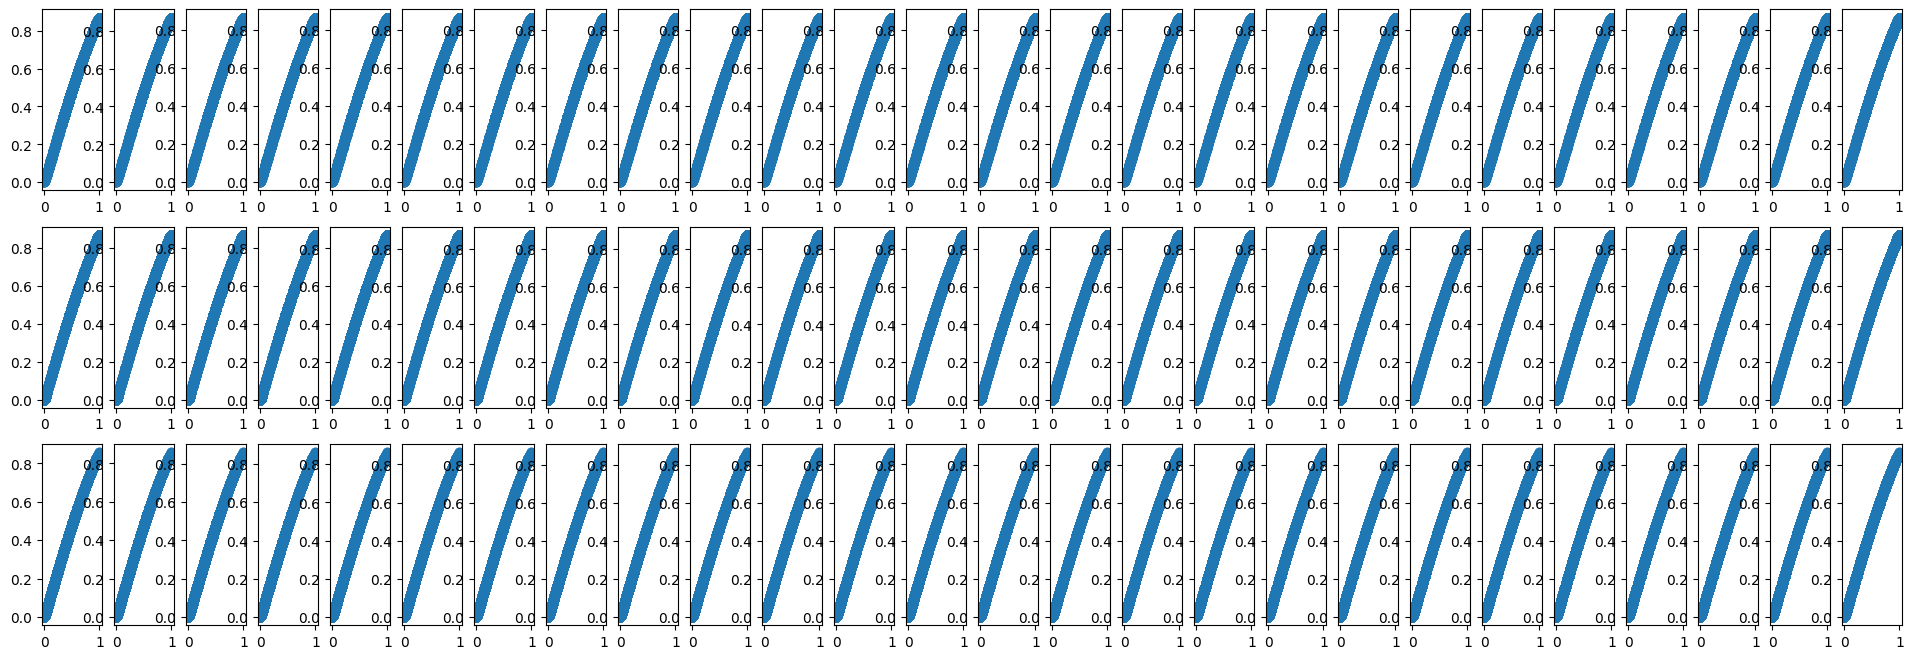

In [172]:
fig, axes = plt.subplots(3, len(states), figsize=(24, 8))
for i in range(len(states)):
    for j in range(3):
        axes[j,i].scatter(kk[...,j].ravel(),
                          intermediates[i]["intermediates"][layer_name]["__call__"][0][...,j].ravel())
plt.show()

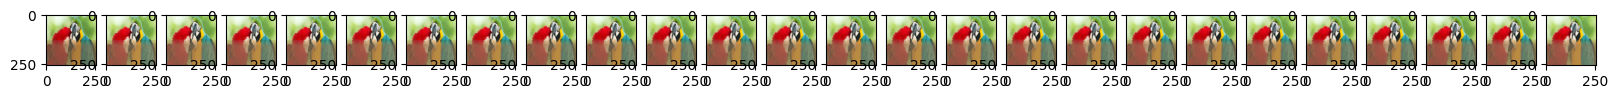

In [81]:
fig, axes = plt.subplots(1, len(states)+1, figsize=(20,8))
axes[0].imshow(kk[0])
for i in range(len(states)):
    axes[i+1].imshow(intermediates[i]["intermediates"][layer_name]["__call__"][0][0]/intermediates[i]["intermediates"][layer_name]["__call__"][0][0].max())
plt.show()

In [222]:
def rmse(a, b): return jnp.sqrt(jnp.sum((a-b)**2, axis=(1,2,3)))

In [223]:
@jax.jit
def obtain_distances(state, batch):
    ref, dist, mos = batch
    pred_ref = forward_pass(state, ref)
    pred_dist = forward_pass(state, dist)
    distance = rmse(pred_ref, pred_dist)
    return distance

In [224]:
import scipy.stats as stats

In [225]:
def obtain_correlation(state, dst):
    distances, moses = [], []
    for batch in dst:
        distance = obtain_distances(state, batch)
        distances.extend(distance)
        moses.extend(batch[2])
        # break
    return stats.pearsonr(distances, moses)[0]

In [3]:
%%time
correlation = obtain_correlation(state, dst_tid2013.as_numpy_iterator())
correlation

CPU times: user 1min 42s, sys: 29.5 s, total: 2min 12s
Wall time: 1min 9s


/home/jorge/miniconda3/envs/dl/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


nan

In [ ]:
metrics_history = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "correlation": [],
}

In [ ]:
%%time
for epoch in range(config.epochs):
    ## Training
    for batch in dst_train_rdy.as_numpy_iterator():
        new_state = train_step(state, batch)
        new_state = new_state.replace(params=clip_layer(new_state.params, "GDN", a_min=0))
        new_state = new_state.replace(params=clip_param(new_state.params, "A", a_min=0))
        new_state = new_state.replace(params=clip_param(new_state.params, "K", a_min=1+1e-5))
        params_diff = jax.tree_map(lambda x, y: jnp.mean((x-y)**2)**(1/2), state.params, new_state.params)
        state = new_state
        wandb.log(unfreeze(params_diff), commit=False)
        # state = compute_metrics(state=state, batch=batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)
    
    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation (Classification)
    for batch in dst_val_rdy.as_numpy_iterator():
        state = val_step(state=state, batch=batch)
        # break
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation (Correlation)
    correlation = obtain_correlation(state, dst_tid2013.as_numpy_iterator())
    metrics_history["correlation"].append(correlation)
    
    ## Checkpointing
    if metrics_history["val_loss"][-1] <= min(metrics_history["val_loss"]):
        orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-best"), state, save_args=save_args, force=True) # force=True means allow overwritting.
    orbax_checkpointer.save(os.path.join(wandb.run.dir, f"model-{epoch}"), state, save_args=save_args, force=False) # force=True means allow overwritting.

    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(state.params).items()}, commit=False)
    wandb.log({"epoch": epoch+1, **{name:values[-1] for name, values in metrics_history.items()}})
    print(f'Epoch {epoch} -> [Train] Loss: {metrics_history["train_loss"][-1]:.3f} Acc: {metrics_history["train_accuracy"][-1]:.3f} [Val] Loss: {metrics_history["val_loss"][-1]:.3f} Acc: {metrics_history["val_accuracy"][-1]:.3f} || Corr: {metrics_history["correlation"][-1]:.3f}')
    # break

Epoch 0 -> [Train] Loss: 2.366 Acc: 0.190 [Val] Loss: 2.370 Acc: 0.204 || Corr: -0.622
Epoch 1 -> [Train] Loss: 2.028 Acc: 0.300 [Val] Loss: 2.454 Acc: 0.205 || Corr: -0.622
Epoch 2 -> [Train] Loss: 1.773 Acc: 0.388 [Val] Loss: 2.580 Acc: 0.202 || Corr: -0.620
Epoch 3 -> [Train] Loss: 1.442 Acc: 0.523 [Val] Loss: 2.824 Acc: 0.191 || Corr: -0.618
Epoch 4 -> [Train] Loss: 1.134 Acc: 0.640 [Val] Loss: 3.159 Acc: 0.187 || Corr: -0.613
Epoch 5 -> [Train] Loss: 0.885 Acc: 0.736 [Val] Loss: 3.545 Acc: 0.185 || Corr: -0.608
Epoch 6 -> [Train] Loss: 0.681 Acc: 0.823 [Val] Loss: 3.970 Acc: 0.183 || Corr: -0.602
Epoch 7 -> [Train] Loss: 0.508 Acc: 0.898 [Val] Loss: 4.423 Acc: 0.183 || Corr: -0.597
Epoch 8 -> [Train] Loss: 0.361 Acc: 0.950 [Val] Loss: 4.892 Acc: 0.177 || Corr: -0.593
Epoch 9 -> [Train] Loss: 0.242 Acc: 0.985 [Val] Loss: 5.361 Acc: 0.176 || Corr: -0.589
Epoch 10 -> [Train] Loss: 0.155 Acc: 0.996 [Val] Loss: 5.808 Acc: 0.173 || Corr: -0.586
Epoch 11 -> [Train] Loss: 0.099 Acc: 0.999

In [ ]:
orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-final"), state, save_args=save_args)

In [ ]:
wandb.finish()